In [1]:
# 1. 確認 GPU 是否可用
import torch
print("GPU 是否可用:", torch.cuda.is_available())
print("GPU 型號:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "無 GPU")

GPU 是否可用: True
GPU 型號: Tesla T4


In [2]:
# 2. 掛載 Google Drive (儲存模型用)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 3. 設定模型儲存路徑
MODEL_PATH = "/content/drive/MyDrive/GPT2_finetuned"

In [9]:
# 4. 安裝必要套件
# !pip install -q transformers datasets accelerate
!pip install -q transformers datasets accelerate --upgrade fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
# 5. 準備數據集
import json

math_ml_qa = [
    {
        "instruction": "What is linear regression?",
        "output": "Linear regression is a statistical method used to model the linear relationship between independent variables (X) and dependent variables (Y). Its basic form is Y = β₀ + β₁X + ε, where β₀ is the intercept, β₁ is the slope, and ε is the error term."
    },
    {
        "instruction": "Explain the gradient descent algorithm",
        "output": "Gradient descent is an optimization algorithm used to find the minimum of a function. It iteratively updates parameters by computing the gradient of the loss function and moving in the negative gradient direction. The learning rate controls the size of each update step."
    },
    {
        "instruction": "What is overfitting? How to prevent it?",
        "output": "Overfitting occurs when a model performs well on training data but poorly on new data. Prevention methods include: 1) Increasing training data 2) Using regularization (L1/L2) 3) Cross-validation 4) Reducing model complexity 5) Using dropout (for neural networks)."
    },
    {
        "instruction": "What is the formula for Bayes' theorem?",
        "output": "Bayes' theorem formula is: P(A|B) = [P(B|A) * P(A)] / P(B), where P(A|B) is the posterior probability, P(B|A) is the likelihood, P(A) is the prior probability, and P(B) is the marginal probability."
    },
    {
        "instruction": "Explain the principle of Support Vector Machines (SVM)",
        "output": "SVM is a supervised learning algorithm that aims to find a hyperplane that separates different classes with maximum margin. For non-linearly separable data, it uses the kernel trick to map data into higher-dimensional space for linear separation."
    },
    {
        "instruction": "What is regularization? Why is it important?",
        "output": "Regularization is a technique that adds penalty terms to the loss function to prevent overfitting. L1 regularization (Lasso) produces sparse solutions, while L2 regularization (Ridge) shrinks parameter values. It's important because it improves model generalization."
    },
    {
        "instruction": "Steps to calculate standard deviation",
        "output": "1) Calculate the mean 2) Compute each data point's difference from the mean 3) Square these differences 4) Calculate the average of squared differences (variance) 5) Take the square root to get standard deviation. Formula: σ = √(Σ(xᵢ - μ)²/N)"
    },
    {
        "instruction": "What are activation functions in neural networks? Give examples",
        "output": "Activation functions determine whether a neuron should be activated, introducing non-linearity. Common types: 1) Sigmoid (0-1) 2) ReLU (0 for negatives, linear for positives) 3) Tanh (-1 to 1) 4) Softmax (multi-class probability output)."
    },
    {
        "instruction": "Explain the meaning of p-value",
        "output": "The p-value is the probability of observing the current or more extreme results assuming the null hypothesis is true. Typically p<0.05 indicates statistical significance to reject the null hypothesis. However, p-value doesn't indicate effect size or hypothesis probability."
    },
    {
        "instruction": "What is Principal Component Analysis (PCA)?",
        "output": "PCA is a dimensionality reduction technique that transforms correlated variables into linearly uncorrelated principal components ordered by variance. The first principal component captures maximum variance, with subsequent components decreasing and orthogonal to previous ones."
    },
    {
        "instruction": "What is the bias-variance tradeoff in machine learning?",
        "output": "Bias is systematic error between model predictions and true values, while variance is model sensitivity to training data variations. Simple models have high bias and low variance, complex models have low bias and high variance. The goal is to find the optimal balance minimizing total error."
    },
    {
        "instruction": "What are Convolutional Neural Networks (CNN)?",
        "output": "CNNs are neural networks specialized for grid-like data (e.g., images), containing convolutional layers (feature extraction), pooling layers (downsampling), and fully connected layers. They reduce parameters through local connectivity and weight sharing, effectively capturing spatial hierarchies."
    },
    {
        "instruction": "How to calculate the dot product of two vectors?",
        "output": "The dot product of two n-dimensional vectors a=[a₁,a₂,...,aₙ] and b=[b₁,b₂,...,bₙ] is calculated as: a·b = a₁b₁ + a₂b₂ + ... + aₙbₙ. Geometrically, it represents the length of one vector's projection onto another multiplied by the length of the other vector."
    },
    {
        "instruction": "Explain the Random Forest algorithm",
        "output": "Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy and robustness. Each tree is trained on random subsets of data and features, with final predictions made by voting (classification) or averaging (regression)."
    },
    {
        "instruction": "What is feature engineering? Provide examples",
        "output": "Feature engineering is the process of creating and selecting the most relevant features to improve model performance. Examples include: 1) Numerical standardization 2) Categorical encoding (one-hot) 3) Creating interaction features 4) Handling missing values 5) Converting text to word vectors."
    },
    {
        "instruction": "Explain ROC curves and AUC",
        "output": "ROC curves plot True Positive Rate (TPR) vs False Positive Rate (FPR) at different thresholds. AUC (Area Under Curve) measures classifier discrimination ability, where 1 indicates perfect classification and 0.5 equals random guessing. AUC is insensitive to class imbalance."
    },
    {
        "instruction": "What is a Markov chain?",
        "output": "A Markov chain is a stochastic process with the Markov property, meaning future states depend only on the current state, not history. Defined by state space and transition probability matrix, it's used to model queuing systems, speech recognition, PageRank, etc."
    },
    {
        "instruction": "How to calculate the inverse of a matrix?",
        "output": "Only square matrices (n×n) with non-zero determinants are invertible. Calculation methods: 1) Adjugate method: A⁻¹ = adj(A)/det(A) 2) Elementary row operations 3) Special formulas for block matrices 4) Numerical methods like LU decomposition."
    },
    {
        "instruction": "What is K-means clustering?",
        "output": "K-means is an unsupervised clustering algorithm with steps: 1) Randomly select K centroids 2) Assign each point to the nearest centroid 3) Recalculate centroid positions 4) Repeat until convergence. It requires specifying K beforehand and is sensitive to initial centroids."
    },
    {
        "instruction": "Explain Monte Carlo simulation",
        "output": "Monte Carlo methods obtain numerical results through repeated random sampling. Applications include: 1) Calculating integrals 2) Risk analysis 3) Physical system simulation 4) Financial option pricing. Results converge to true values as samples increase."
    },
    {
        "instruction": "What is Residual Sum of Squares (RSS)?",
        "output": "RSS is the sum of squared differences between predicted and actual values in regression models: RSS = Σ(yᵢ - ŷᵢ)². It measures model goodness-of-fit and is the optimization target for least squares estimation in linear regression."
    },
    {
        "instruction": "Explain backpropagation in neural networks",
        "output": "Backpropagation is a neural network training algorithm that calculates gradients of the loss function with respect to each layer's parameters using chain rule. Steps: 1) Forward pass computes output 2) Calculate loss 3) Backpropagate gradients 4) Update weights with gradient descent."
    },
    {
        "instruction": "What are covariance and correlation?",
        "output": "Covariance measures how two variables change together: cov(X,Y)=E[(X-μₓ)(Y-μᵧ)]. Correlation is standardized covariance: ρ=cov(X,Y)/(σₓσᵧ), ranging [-1,1], unaffected by scale."
    },
    {
        "instruction": "How to calculate combinations C(n,k)?",
        "output": "Combinations C(n,k) calculate unordered selections of k items from n: C(n,k) = n! / [k!(n-k)!]. Properties include symmetry C(n,k)=C(n,n-k) and recurrence relation C(n,k)=C(n-1,k)+C(n-1,k-1)."
    },
    {
        "instruction": "What is the Lagrange multiplier method?",
        "output": "Lagrange multipliers optimize functions under constraints. The Lagrange function is L(x,y,λ)=f(x,y)-λg(x,y), where g(x,y)=0 is the constraint. Solving ∇L=0 finds extrema, with λ indicating constraint impact strength."
    },
    {
        "instruction": "Explain the ID3 algorithm for decision trees",
        "output": "ID3 builds decision trees by selecting features with maximum information gain. Steps: 1) Calculate dataset entropy 2) Compute conditional entropy for each feature 3) Split by feature with maximum gain 4) Recurse on subsets. It favors multi-valued features."
    },
    {
        "instruction": "What is Newton's method?",
        "output": "Newton's method finds function roots via iteration: xₙ₊₁ = xₙ - f(xₙ)/f'(xₙ). For optimization (finding extrema), it's called Newton-Raphson and uses second derivatives. Fast convergence but requires derivatives and may not converge."
    },
    {
        "instruction": "How to calculate confidence intervals?",
        "output": "For mean μ's 95% CI: 1) Compute sample mean x̄ and standard error SE=s/√n 2) Find critical value t* from t-distribution 3) CI = x̄ ± t*×SE. For large samples, use z-scores instead of t-scores."
    },
    {
        "instruction": "What are eigenvalues and eigenvectors?",
        "output": "For square matrix A, if Av=λv for non-zero vector v and scalar λ, then λ is an eigenvalue and v is its eigenvector. Physically, eigenvectors maintain direction under linear transformation, only scaled by λ."
    },
    {
        "instruction": "Explain the Naive Bayes classifier",
        "output": "Naive Bayes uses Bayes' theorem with strong feature independence assumptions. Despite this, it performs well in text classification etc. Types include: 1) Gaussian 2) Multinomial 3) Bernoulli. Computationally efficient and good for high-dimensional data."
    },
    {
        "instruction": "What is heteroscedasticity? How to detect it?",
        "output": "Heteroscedasticity occurs when error term variances aren't constant in regression models. Detection methods: 1) Residual plots 2) Breusch-Pagan test 3) White test. Solutions include weighted least squares or variable transformations."
    },
    {
        "instruction": "How to calculate determinants?",
        "output": "Determinant calculation methods: 1) Small matrices (2×2): ad-bc 2) Laplace expansion by row/column 3) Diagonal method (Sarrus rule for 3×3 only) 4) LU decomposition into diagonal product 5) Properties: Row swaps don't change value, linear combinations affect it."
    },
    {
        "instruction": "What is ensemble learning? Provide examples",
        "output": "Ensemble learning combines multiple base learners to improve performance. Examples: 1) Bagging (parallel, e.g., Random Forest) 2) Boosting (sequential, e.g., AdaBoost) 3) Stacking (meta-model combines predictions). Reduces variance and bias for better generalization."
    },
    {
        "instruction": "Explain Maximum Likelihood Estimation (MLE)",
        "output": "MLE estimates parameters θ by maximizing likelihood function L(θ|X)=P(X|θ). Steps: 1) Write likelihood function 2) Take logarithm for summation 3) Differentiate w.r.t. θ 4) Solve likelihood equations. For normal distributions, MLE matches least squares."
    },
    {
        "instruction": "What is attention mechanism?",
        "output": "Attention enables neural networks to dynamically focus on different input parts. Steps: 1) Compute queries (Q), keys (K), values (V) 2) Attention scores=QKᵀ/√dₖ 3) Softmax normalization 4) Weighted sum attention output=scores·V. Core component of Transformers."
    },
    {
        "instruction": "How to solve systems of linear equations?",
        "output": "Solution methods: 1) Gaussian elimination 2) Matrix inversion (square only) 3) LU decomposition 4) Cramer's rule (small systems) 5) Iterative methods (e.g., Jacobi) 6) Least squares (no solution). Choice depends on matrix size, sparsity, and condition number."
    },
    {
        "instruction": "What are Generative Adversarial Networks (GANs)?",
        "output": "GANs consist of generator (creates fake data) and discriminator (detects fakes) trained adversarially. The objective is min_G max_D V(D,G), where generator minimizes while discriminator maximizes. Used for image generation, style transfer, etc."
    },
    {
        "instruction": "Explain ARIMA models for time series",
        "output": "ARIMA(p,d,q) contains: 1) AR(p): Autoregression using past values 2) I(d): Differencing to make series stationary 3) MA(q): Moving average using past errors. Modeling steps: identification → estimation → testing → forecasting."
    },
    {
        "instruction": "What is dimensionality reduction? Why important?",
        "output": "Dimensionality reduction transforms high-dimensional data into lower dimensions while preserving key information. Importance: 1) Visualization 2) Reducing computation 3) Mitigating curse of dimensionality 4) Removing noise. Methods include PCA, t-SNE, autoencoders."
    },
    {
        "instruction": "How to calculate conditional probability?",
        "output": "Conditional probability P(A|B) is probability of A given B occurs: P(A|B) = P(A∩B)/P(B). For independent events, P(A|B)=P(A). Bayes' theorem reverses conditional probabilities."
    },
    {
        "instruction": "What are Hopfield networks?",
        "output": "Hopfield networks are fully connected recurrent neural networks serving as content-addressable memory. Features: 1) Symmetric weights 2) Asynchronous updates 3) Energy function guarantees convergence 4) Storage capacity ~0.14n. Used for optimization and pattern recognition."
    },
    {
        "instruction": "Explain K-Nearest Neighbors (KNN) algorithm",
        "output": "KNN is a lazy learning algorithm predicting based on a test sample's K nearest training samples (majority vote for classification, average for regression). Key parameters: 1) K value 2) Distance metric (e.g., Euclidean) 3) Weight function. Sensitive to local structure."
    },
    {
        "instruction": "What is the Fourier transform?",
        "output": "The Fourier transform decomposes time-domain signals into frequency representation: F(ω)=∫f(t)e^(-iωt)dt. Discrete version (DFT) works for digital signals, with FFT algorithm reducing complexity. Applications include signal processing, image analysis, and solving differential equations."
    },
    {
        "instruction": "How to evaluate classifier performance?",
        "output": "Evaluation metrics: 1) Accuracy 2) Precision and recall 3) F1 score 4) ROC-AUC 5) Confusion matrix 6) Log loss. Choice depends on needs, e.g., prioritizing recall over accuracy for imbalanced classes."
    },
    {
        "instruction": "What are Markov Decision Processes (MDPs)?",
        "output": "MDPs are reinforcement learning frameworks with (S,A,P,R,γ): state space S, actions A, transition probabilities P, rewards R, discount factor γ. The goal is finding policy π maximizing expected cumulative reward. Solved via value or policy iteration."
    },
    {
        "instruction": "Explain the EM algorithm",
        "output": "Expectation-Maximization (EM) estimates parameters for probabilistic models with latent variables. Steps: 1) E-step: Compute expected latent variables 2) M-step: Update parameters by maximizing expected likelihood. Guarantees likelihood improvement per iteration but may converge to local optima. Used in Gaussian Mixture Models etc."
    },
    {
        "instruction": "What are word embeddings? Provide examples",
        "output": "Word embeddings map words to low-dimensional vector spaces where semantically similar words have similar vectors. Examples: 1) Word2Vec (skip-gram/CBOW) 2) GloVe (global statistics) 3) FastText (subword information). Can solve analogies like king-queen=man-woman."
    },
    {
        "instruction": "How to calculate area under curve (AUC)?",
        "output": "AUC calculation methods: 1) Analytical (integrate known function) 2) Numerical integration (trapezoidal, Simpson's rules) 3) Monte Carlo (random sampling) 4) For ROC curves, AUC via trapezoidal rule or Wilcoxon-Mann-Whitney statistic."
    },
    {
        "instruction": "What are Long Short-Term Memory (LSTM) networks?",
        "output": "LSTMs are RNNs with gating mechanisms solving long-term dependency problems. Contains: 1) Input gate 2) Forget gate 3) Output gate 4) Memory cell. Can selectively remember/forget information, suitable for sequence modeling (speech, text, time series)."
    },
        {
        "instruction": "Explain the Central Limit Theorem and its importance",
        "output": "The Central Limit Theorem states that the sampling distribution of the mean approaches a normal distribution as sample size increases, regardless of the population's distribution. This is crucial because it allows for statistical inference (confidence intervals, hypothesis testing) even when population distributions are unknown."
    },
    {
        "instruction": "What is the difference between batch, stochastic, and mini-batch gradient descent?",
        "output": "1) Batch GD uses the entire dataset to compute gradients (accurate but computationally expensive). 2) Stochastic GD uses single random samples (noisy but fast updates). 3) Mini-batch GD uses small random subsets (balance between efficiency and stability). Mini-batch is most common in deep learning."
    },
    {
        "instruction": "Describe the Transformer architecture and its key components",
        "output": "Transformers consist of: 1) Multi-head self-attention (captures relationships between all positions) 2) Position-wise feed-forward networks 3) Layer normalization and residual connections 4) Positional encodings (for sequence order). The architecture enables parallel processing and handles long-range dependencies better than RNNs."
    },
    {
        "instruction": "How does XGBoost differ from regular gradient boosting?",
        "output": "XGBoost improves upon regular gradient boosting with: 1) Regularization terms (L1/L2) in the objective function 2) More efficient tree pruning 3) Handling missing values 4) Built-in cross-validation 5) Hardware optimization. These make it faster and less prone to overfitting."
    },
    {
        "instruction": "What are precision and recall? How are they related to the confusion matrix?",
        "output": "Precision = TP/(TP+FP) (accuracy of positive predictions). Recall = TP/(TP+FN) (fraction of positives identified). From confusion matrix: TP=true positives, FP=false positives, FN=false negatives. There's typically a tradeoff between them - increasing recall often decreases precision."
    },
    {
        "instruction": "Explain the concept of embeddings in natural language processing",
        "output": "Word embeddings are dense vector representations where semantically similar words have similar vectors. They capture: 1) Semantic relationships (king - man + woman ≈ queen) 2) Syntactic patterns 3) Contextual meaning. Popular methods include Word2Vec, GloVe, and contextual embeddings like BERT."
    },
    {
        "instruction": "What is the difference between parametric and non-parametric models?",
        "output": "Parametric models (e.g., linear regression) have fixed number of parameters regardless of data size. Non-parametric models (e.g., k-NN, decision trees) grow in complexity with more data. Parametric: faster but makes stronger assumptions. Non-parametric: more flexible but needs more data."
    },
    {
        "instruction": "Describe the bias-variance decomposition of generalization error",
        "output": "Expected prediction error = Bias² + Variance + Irreducible error. Bias: error from overly simple assumptions. Variance: error from sensitivity to small fluctuations in training set. As model complexity increases, bias decreases but variance increases, creating the tradeoff."
    },
    {
        "instruction": "What are the assumptions of linear regression?",
        "output": "Key assumptions: 1) Linear relationship between X and Y 2) Independent observations 3) Homoscedasticity (constant error variance) 4) Normally distributed errors 5) Little/no multicollinearity 6) No auto-correlation (time series). Violations can lead to biased or inefficient estimates."
    },
    {
        "instruction": "Explain how dropout works in neural networks",
        "output": "Dropout randomly deactivates neurons during training with probability p (typically 0.2-0.5). This: 1) Prevents co-adaptation of neurons 2) Acts as approximate model averaging 3) Provides regularization. During testing, all neurons are active but weights are scaled by 1-p to maintain expected outputs."
    },
    {
        "instruction": "What is the chain rule in calculus and why is it important for deep learning?",
        "output": "The chain rule computes derivatives of composite functions: dz/dx = dz/dy * dy/dx. In deep learning, it enables backpropagation - efficiently calculating gradients through nested layers by multiplying local derivatives. This makes training multi-layer networks computationally feasible."
    },
    {
        "instruction": "Describe the k-fold cross-validation process",
        "output": "Steps: 1) Randomly split data into k equal folds 2) For each fold: a) Use as test set b) Train on remaining k-1 folds c) Compute performance metric 3) Average results across all folds. Common choices: k=5 or 10. Provides more reliable performance estimate than single train-test split."
    },
    {
        "instruction": "What is the difference between supervised, unsupervised, and reinforcement learning?",
        "output": "Supervised: Learns from labeled examples (input-output pairs). Unsupervised: Finds patterns in unlabeled data (clustering, dimensionality reduction). Reinforcement: Learns through rewards/punishments from environment. Semi-supervised combines labeled and unlabeled data."
    },
    {
        "instruction": "Explain how the attention mechanism works in Transformers",
        "output": "1) Project inputs to Query, Key, Value matrices 2) Compute attention scores as QKᵀ/√dₖ 3) Apply softmax for weights 4) Weighted sum of Values. Multi-head attention does this in parallel with different learned projections, allowing focus on different aspects simultaneously."
    },
    {
        "instruction": "What is the curse of dimensionality?",
        "output": "In high dimensions: 1) Data becomes sparse (distance metrics lose meaning) 2) Need exponentially more samples for same coverage 3) Models become more complex and prone to overfitting. This motivates dimensionality reduction techniques like PCA for high-dimensional data."
    },
    {
        "instruction": "Describe the Adam optimization algorithm",
        "output": "Adam combines: 1) Momentum (averages past gradients) 2) RMSprop (adapts learning rates per parameter). It maintains exponentially decaying averages of both gradients (first moment) and squared gradients (second moment), with bias correction. Default parameters often work well."
    },
    {
        "instruction": "What is the difference between bagging and boosting?",
        "output": "Bagging (e.g., Random Forest): 1) Trains models in parallel 2) Reduces variance 3) Uses bootstrap sampling 4) Averages predictions. Boosting (e.g., AdaBoost): 1) Trains sequentially 2) Reduces bias 3) Focuses on misclassified examples 4) Weighted voting."
    },
    {
        "instruction": "Explain the concept of learning rate in gradient descent",
        "output": "The learning rate (α) controls step size in parameter updates. Too high: overshoot minimum, diverge. Too low: slow convergence, may get stuck. Can be: 1) Fixed 2) Adaptive (Adam, AdaGrad) 3) Scheduled (decay over time). Learning rate warmup helps Transformer training."
    },
    {
        "instruction": "What are autoencoders? Describe their architecture and uses",
        "output": "Autoencoders are neural networks that learn efficient data encodings by: 1) Encoder: compresses input to latent representation 2) Decoder: reconstructs input from latent code. Used for: 1) Dimensionality reduction 2) Denoising 3) Anomaly detection 4) Feature learning. Variational autoencoders generate new data."
    },
    {
        "instruction": "Explain the concept of information gain in decision trees",
        "output": "Information gain measures how much a feature reduces entropy (uncertainty) about the target: IG = H(parent) - Σ[(N_child/N_parent)*H(child)]. Decision trees recursively split on features with highest information gain until stopping criteria (max depth, minimum samples, etc.)."
    },
    {
        "instruction": "What is the difference between Type I and Type II errors?",
        "output": "Type I (false positive): Rejecting true null hypothesis. Type II (false negative): Failing to reject false null. Significance level (α) controls Type I error rate. Power (1-β) relates to Type II error. There's typically a tradeoff - reducing one increases the other for fixed sample size."
    },
    {
        "instruction": "Describe how t-SNE works for dimensionality reduction",
        "output": "t-SNE: 1) Computes pairwise similarities in high-dim space 2) Maps to low-dim space preserving these similarities 3) Uses Student-t distribution for low-dim similarities (heavy tails prevent crowding). Good for visualization (2D/3D) but computationally expensive and results vary with perplexity parameter."
    },
    {
        "instruction": "What is the difference between batch normalization and layer normalization?",
        "output": "BatchNorm: 1) Normalizes across batch dimension 2) Needs large enough batches 3) Sensitive to batch size. LayerNorm: 1) Normalizes across feature dimension 2) Works with small batches 3) Common in Transformers. Both stabilize training and help with vanishing gradients."
    },
    {
        "instruction": "Explain the concept of residual connections in neural networks",
        "output": "Residual connections add a layer's input to its output: y = F(x) + x. Benefits: 1) Helps gradients flow through deep networks 2) Enables training very deep models (ResNets) 3) Network can learn identity functions easily. Often used with normalization (e.g., LayerNorm) before the residual addition."
    },
    {
        "instruction": "What is the difference between generative and discriminative models?",
        "output": "Generative models (e.g., GANs, VAEs) learn joint distribution P(X,Y) and can generate new samples. Discriminative models (e.g., logistic regression, CNNs) learn conditional distribution P(Y|X). Generative models are typically more flexible but harder to train and evaluate."
    },
    {
        "instruction": "Describe the architecture of a variational autoencoder (VAE)",
        "output": "VAE consists of: 1) Encoder: maps input to distribution parameters (mean, variance) in latent space 2) Sampling: generates latent vector z using reparameterization trick 3) Decoder: reconstructs input from z. Trained to maximize evidence lower bound (ELBO), balancing reconstruction quality and latent space regularization."
    },
    {
        "instruction": "What is the difference between L1 and L2 regularization?",
        "output": "L1 (Lasso): 1) Adds absolute value of weights to loss 2) Produces sparse models (feature selection) 3) Robust to outliers. L2 (Ridge): 1) Adds squared weights to loss 2) Shrinks weights smoothly 3) Has analytic solution. Elastic Net combines both. Choice depends on problem - L1 for feature selection, L2 for multicollinearity."
    },
    {
        "instruction": "Explain the concept of early stopping in machine learning",
        "output": "Early stopping: 1) Monitors validation performance during training 2) Stops when performance stops improving 3) Returns weights from best validation step. Benefits: 1) Prevents overfitting 2) Saves computation 3) Often works as well as explicit regularization. Need large enough validation set for reliability."
    },
    {
        "instruction": "What is the difference between RNNs and LSTMs?",
        "output": "RNNs: 1) Process sequences step-by-step 2) Maintain hidden state 3) Suffer from vanishing gradients. LSTMs: 1) Add gating mechanisms (input, forget, output gates) 2) Maintain cell state 3) Better at learning long-range dependencies. GRUs are similar to LSTMs but with fewer gates (reset and update)."
    },
    {
        "instruction": "Describe the concept of transfer learning in deep learning",
        "output": "Transfer learning: 1) Pretrain model on large dataset (e.g., ImageNet) 2) Adapt to new task via: a) Feature extraction (use pretrained as fixed feature extractor) b) Fine-tuning (update some/all weights). Especially useful when target dataset is small. Common in NLP (BERT) and computer vision (ResNet)."
    }

]

In [11]:
# 6. 數據預處理
def format_example(example):
    return {
        "text": f"Question: {example['instruction']}\nAnswer: {example['output']}",
        "instruction": example["instruction"],
        "output": example["output"]
    }

formatted_data = [format_example(q) for q in math_ml_qa]

In [12]:
# 7. 保存為JSON文件
import json
with open('math_qa_dataset.json', 'w', encoding='utf-8') as f:
    json.dump(formatted_data, f, ensure_ascii=False, indent=2)


In [13]:
# 8. 加載數據集
from datasets import load_dataset, DatasetDict

dataset = load_dataset('json', data_files='math_qa_dataset.json')['train']
dataset = dataset.train_test_split(test_size=0.2, seed=123) # 80%訓練，20%測試

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
# 9. 加載tokenizer和模型
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # 設置pad token

# 先加載配置並修改dropout
config = GPT2Config.from_pretrained("gpt2")
config.resid_pdrop = 0.1    # 殘差連接的dropout
config.embd_pdrop = 0.1     # embedding層的dropout
config.attn_pdrop = 0.1     # attention層的dropout

# 使用LMHeadModel而不是SequenceClassification，加載模型
model = GPT2LMHeadModel.from_pretrained("gpt2", config=config)  # 增加Dropout 10%

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [18]:
# 10. Tokenization函數，分別對訓練集和測試集進行tokenization

# def tokenize_function(examples):
#     # 組合問答文本
#     texts = [f"Question: {q}\nAnswer: {a}" for q, a in zip(examples['instruction'], examples['output'])]

#     # Tokenize文本
#     tokenized = tokenizer(
#         texts,
#         padding="max_length",
#         truncation=True,
#         max_length=128,
#         return_tensors="pt"
#     )

#     # 對於語言模型，labels應該與input_ids相同
#     tokenized["labels"] = tokenized["input_ids"].clone()

#     return tokenized


def tokenize_function(examples):
    texts = [f"Question: {q}\nAnswer: {a}" for q, a in zip(examples['instruction'], examples['output'])]
    tokenized = tokenizer(texts, padding="max_length", truncation=True, max_length=128)
    tokenized["labels"] = tokenized["input_ids"].copy()  # 關鍵：設置labels
    return tokenized

tokenized_datasets = DatasetDict({
    "train": dataset["train"].map(tokenize_function, batched=True),
    "test": dataset["test"].map(tokenize_function, batched=True)
})


Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

In [19]:
small_train_dataset = tokenized_datasets["train"]  # 使用全部訓練數據
small_eval_dataset = tokenized_datasets["test"]    # 使用全部測試數據

# print(f"訓練集樣本數: {len(small_train_dataset)}")
# print(f"測試集樣本數: {len(small_eval_dataset)}")

In [20]:
# 11. 應用tokenization
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['instruction', 'output', 'text']  # 移除原始列
)

Map:   0%|          | 0/63 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

In [21]:
# # 檢查第一個樣本的數據格式

# sample = tokenized_datasets["train"][0]
# print("Input IDs:", sample["input_ids"][:10])
# print("Labels:", sample["labels"][:10])  # 應與input_ids相同
# print("Attention Mask:", sample["attention_mask"][:10])

In [22]:
# # 驗證模型能否正常前向傳播
# test_output = model(
#     input_ids=torch.tensor([sample["input_ids"]]),
#     attention_mask=torch.tensor([sample["attention_mask"]]),
#     labels=torch.tensor([sample["labels"]])
# )
# print("Test Loss:", test_output.loss.item())

In [28]:
# 快速測試配置（使用完整數據流程但減少epoch）

from transformers import TrainingArguments, Trainer, EarlyStoppingCallback


# # 12. 快速測試，快速檢查流程是否正常
# quick_args = TrainingArguments(
#     output_dir="./quick_test",
#     num_train_epochs=1,                # 只跑1個epoch
#     per_device_train_batch_size=2,     # 很小的batch_size
#     evaluation_strategy="steps",       # 50步監測一次
#     eval_steps=50,
#     logging_steps=10,                  # 監測log
#     save_strategy="no",                # 快速測試時不保存
#     report_to="none"                   # 禁用wandb
# )

# ============ 【快速驗證】 ============
# 在正式訓練前執行，用少量數據/epoch快速檢查
quick_args = TrainingArguments(
    output_dir="./quick_test",
    num_train_epochs=1,                # 只跑1個epoch
    per_device_train_batch_size=2,     # 極小batch_size
    evaluation_strategy="steps",       # 每50步驗證一次
    eval_steps=10,
    logging_steps=1,                   # 密集監控log
    save_total_limit=1
)

# 13. 執行快速驗證
print("開始快速驗證...")
quick_trainer = Trainer(
    model=model,
    args=quick_args,
    train_dataset=tokenized_datasets["train"].select(range(10)),  # 10個樣本
    eval_dataset=tokenized_datasets["test"].select(range(5)),     # 5個樣本
)

quick_result = quick_trainer.train()
print("最後評估結果:", quick_trainer.evaluate())

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


開始快速驗證...


Step,Training Loss,Validation Loss


最後評估結果: {'eval_loss': 1.6679919958114624, 'eval_runtime': 0.0831, 'eval_samples_per_second': 60.165, 'eval_steps_per_second': 12.033, 'epoch': 1.0}


In [29]:
# 快速驗證結果（從trainer.state獲取日誌）
if len(quick_trainer.state.log_history) > 0:
    last_log = quick_trainer.state.log_history[-1]
    print("最後一條日誌記錄:", last_log)

    if "eval_loss" in last_log:
        if last_log["eval_loss"] > 10:
            raise ValueError(f"異常高的eval_loss: {last_log['eval_loss']}")
        else:
            print(f"快速驗證通過，最終eval_loss: {last_log['eval_loss']}")
    else:
        print("未找到eval_loss記錄，請確認evaluation_strategy設置正確")
else:
    raise RuntimeError("沒有任何訓練日誌被記錄")

最後一條日誌記錄: {'eval_loss': 1.6679919958114624, 'eval_runtime': 0.0831, 'eval_samples_per_second': 60.165, 'eval_steps_per_second': 12.033, 'epoch': 1.0, 'step': 5}
快速驗證通過，最終eval_loss: 1.6679919958114624


In [30]:
# 如果快速驗證loss很高：檢查tokenization後的樣本：
print("第一個樣本的input_ids:", tokenized_datasets["train"][0]["input_ids"])
print("第一個樣本的labels:", tokenized_datasets["train"][0]["labels"])

第一個樣本的input_ids: [24361, 25, 1867, 318, 262, 10690, 12, 25641, 590, 3292, 2364, 287, 4572, 4673, 30, 198, 33706, 25, 347, 4448, 318, 17895, 4049, 1022, 2746, 16277, 290, 2081, 3815, 11, 981, 24198, 318, 2746, 14233, 284, 3047, 1366, 13991, 13, 17427, 4981, 423, 1029, 10690, 290, 1877, 24198, 11, 3716, 4981, 423, 1877, 10690, 290, 1029, 24198, 13, 383, 3061, 318, 284, 1064, 262, 16586, 5236, 41366, 2472, 4049, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
第一個樣本的labels: [24361, 25, 1867, 318, 262, 10690, 12, 25641, 590, 3292, 2364, 287, 4572, 4673, 30, 198, 33706, 25, 347, 4448, 318, 17895, 4049, 1022, 2746, 16277, 290, 2081, 3815

In [31]:
# 確保模型在正確設備上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 修正後的數據驗證代碼
sample = tokenized_datasets["train"][0]
sample = {k: torch.tensor([v]).to(device) for k, v in sample.items()}  # 關鍵修改：添加.to(device)

# 現在可以安全運行
outputs = model(**sample)
print("測試樣本的loss:", outputs.loss.item())

測試樣本的loss: 1.6006724834442139


In [32]:
# 12. 訓練參數設置

# training_args = TrainingArguments(
#     output_dir=MODEL_PATH,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     num_train_epochs=3, # 訓練3個epoch
#     logging_dir='./logs',
#     save_strategy="epoch", # 每個epoch都保存
#     evaluation_strategy="epoch", # 每個epoch都評估
#     learning_rate=5e-5,
#     weight_decay=0.01,
#     fp16=True if torch.cuda.is_available() else False, # 檢測GPU
#     gradient_accumulation_steps=4,
#     report_to="none"  # 禁用wandb
# )

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    num_train_epochs=10,                # 訓練3個epoch
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    logging_steps=1,                  # 每20步記錄一次log
    eval_steps=100,                    # 每100步評估一次
    save_strategy="epoch",             # 每個epoch都保存
    evaluation_strategy="epoch",       # 每個epoch都評估  # "steps", # 按步數評估
    learning_rate=5e-5,
    weight_decay=0.05,                 # 增大權重衰減（L2正則化）
    lr_scheduler_type="cosine",        # 使用餘弦退火調整學習率
    warmup_steps=100,                  # 初始逐步增加學習率
    fp16=True if torch.cuda.is_available() else False, # 檢測GPU
    gradient_accumulation_steps=4,
    report_to="none",                  # 禁用wandb
    load_best_model_at_end=True,        # 訓練結束時加載最佳模型
    metric_for_best_model="eval_loss",  # 指定監控指標
    greater_is_better=False            # eval_loss越小越好
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
# 13. 創建Trainer，最終訓練應使用完整數據集
from transformers import Trainer

print("快速驗證成功！開始正式訓練...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"], # 完整訓練集
    eval_dataset=tokenized_datasets["test"], # 完整測試集
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # 設定early stop
)

快速驗證成功！開始正式訓練...


In [38]:
# 14. 開始訓練
train_result = trainer.train()

Epoch,Training Loss,Validation Loss
1,2.312600,2.089116
2,2.261800,2.073278
3,2.466800,2.048126
4,2.295700,2.020061
5,2.121400,1.988783
6,2.143200,1.956830
7,2.096400,1.926709
8,2.033200,1.900556
9,1.938100,1.876276
10,1.801900,1.851678


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


In [39]:
# 15. 保存模型

#(一)
# model.save_pretrained(MODEL_PATH)  # 只保存模型權重和配置
# tokenizer.save_pretrained(MODEL_PATH)  # 單獨保存tokenizer

#(二)
trainer.save_model(MODEL_PATH)  # 自動保存模型+tokenizer+訓練狀態
print(f"✅ 模型已保存至: {MODEL_PATH}")

✅ 模型已保存至: /content/drive/MyDrive/GPT2_finetuned


In [40]:
# 安全獲取eval_loss的方式
if hasattr(trainer, 'state') and trainer.state.log_history:
    last_log = trainer.state.log_history[-1]
    if "eval_loss" in last_log:
        print(f"最終評估loss: {last_log['eval_loss']}")
    else:
        print("未找到eval_loss，最後一條記錄包含:", last_log.keys())
else:
    print("無訓練日誌記錄")

# 手動執行最終評估（確保一定有結果）
eval_results = trainer.evaluate()
print(f"\n手動評估結果: {eval_results}")

# 查看完整日誌歷史
for log in trainer.state.log_history[-5:]:  # 打印最後5條記錄
    print(log)

未找到eval_loss，最後一條記錄包含: dict_keys(['train_runtime', 'train_samples_per_second', 'train_steps_per_second', 'total_flos', 'train_loss', 'epoch', 'step'])



手動評估結果: {'eval_loss': 1.8516778945922852, 'eval_runtime': 0.1525, 'eval_samples_per_second': 104.938, 'eval_steps_per_second': 26.235, 'epoch': 10.0}
{'loss': 1.9955, 'grad_norm': 3.5413317680358887, 'learning_rate': 1.9e-05, 'epoch': 9.75, 'step': 39}
{'loss': 1.8019, 'grad_norm': 3.512860059738159, 'learning_rate': 1.9500000000000003e-05, 'epoch': 10.0, 'step': 40}
{'eval_loss': 1.8516778945922852, 'eval_runtime': 0.5613, 'eval_samples_per_second': 28.507, 'eval_steps_per_second': 7.127, 'epoch': 10.0, 'step': 40}
{'train_runtime': 414.4161, 'train_samples_per_second': 1.52, 'train_steps_per_second': 0.097, 'total_flos': 41153495040000.0, 'train_loss': 2.1796803176403046, 'epoch': 10.0, 'step': 40}
{'eval_loss': 1.8516778945922852, 'eval_runtime': 0.1525, 'eval_samples_per_second': 104.938, 'eval_steps_per_second': 26.235, 'epoch': 10.0, 'step': 40}


In [41]:
print(f"訓練樣本數: {len(dataset['train'])}")
print(f"實際總步數: {len(dataset['train']) // (4*4) * 5}")

訓練樣本數: 63
實際總步數: 15


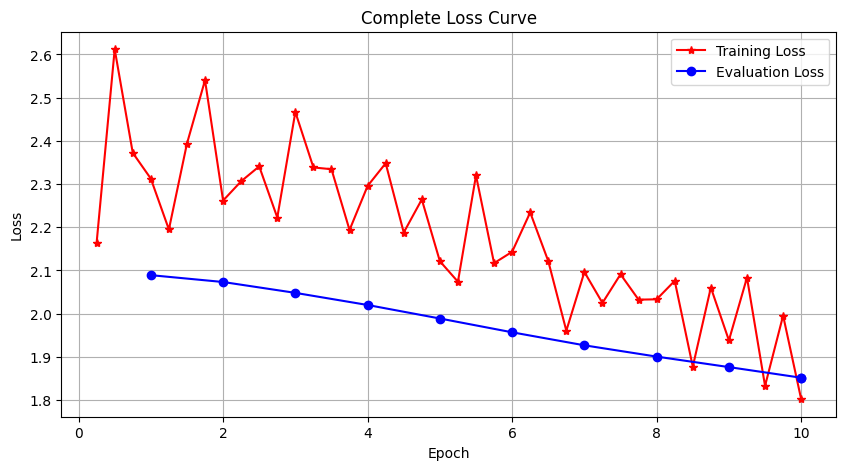

In [42]:
# 在Notebook中實時繪製loss曲線
import matplotlib.pyplot as plt

# losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
# plt.plot(losses)
# plt.title('Training Loss')
# plt.show()

# 提取所有可能包含loss的記錄
all_logs = trainer.state.log_history

# 過濾有效記錄
train_logs = [log for log in all_logs if 'loss' in log and 'epoch' in log]
eval_logs = [log for log in all_logs if 'eval_loss' in log]

# 繪製完整曲線
plt.figure(figsize=(10, 5))

if train_logs:
    plt.plot([log['epoch'] for log in train_logs],
             [log['loss'] for log in train_logs],
             'r*-', label='Training Loss')

if eval_logs:
    plt.plot([log['epoch'] for log in eval_logs],
             [log['eval_loss'] for log in eval_logs],
             'bo-', label='Evaluation Loss')

plt.title('Complete Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# # 實時監控訓練過程（在Colab中直接輸出）
# !tail -f ./logs/trainer_log.jsonl

In [55]:
# 16. 測試模型
from transformers import pipeline

text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# 測試生成
sample_text = "What is linear regression?"

generated_texts = text_generator(
    sample_text,
    max_length=150,
    num_return_sequences=1,       # 生成結果數量
    temperature=0.7,              # 控制隨機性 (0.1~1.0)
    top_p=0.9                     # 核採樣 (0.9~0.95)
)
print("生成的結果:", generated_texts[0]["generated_text"])


Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


生成的結果: What is linear regression?
Answer: Linear regression is the method for estimating linear trends in the mean of continuous data (logarithmistic regression). Linear regression is based on the idea that there is a continuous variable and an error term. For linear regression, the error term is a function of the number of continuous variables. For logarithmic regression, the error term is the difference between the mean squared and the error term.


In [54]:
# from transformers import pipeline

# # 在文本生成時加入約束條件，要將 generation_args 的參數整合到生成函數中:

# # 初始化文本生成器
# text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# # 綜合生成參數
# generation_args = {
#     "max_new_tokens": 100,
#     "do_sample": True,
#     "temperature": 0.7,
#     "top_k": 30,             # 限制候選詞數量
#     "top_p": 0.9,            # 核採樣 (0.9~0.95)
#     "repetition_penalty": 1.2, # 重複懲罰
#     "num_return_sequences": 1  # 生成結果數量
# }

# # 測試生成
# sample_text = "What is linear regression?"
# generated_texts = text_generator(sample_text, **generation_args)
# print("生成的結果:", generated_texts[0]["generated_text"])

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


生成的結果: What is linear regression?
Answer: Linear regression measures how well a model predicts future events. For example, if we assume that the probability of an event being predicted by random chance increases as it gets closer to zero (say), then our models predict better than average over time because there's more variance in probabilities across different periods and thus fewer outliers are lost due less accurate predictions relative for some groups or variables compared with others.
